In [3]:
project_id = 'robotic-augury-476017-j6'
data_set_id = 'security_analysis'
table_name = 'feature_query_output_t'

Model Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     95000
         1.0       0.80      0.51      0.62      5000

    accuracy                           0.97    100000
   macro avg       0.89      0.75      0.80    100000
weighted avg       0.97      0.97      0.97    100000



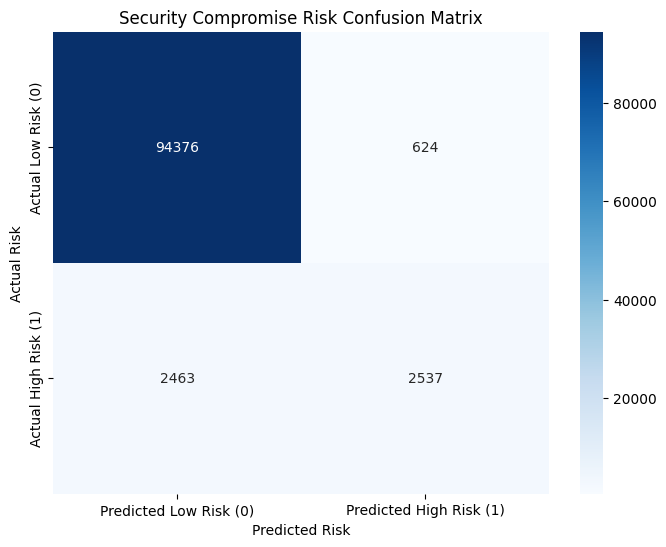

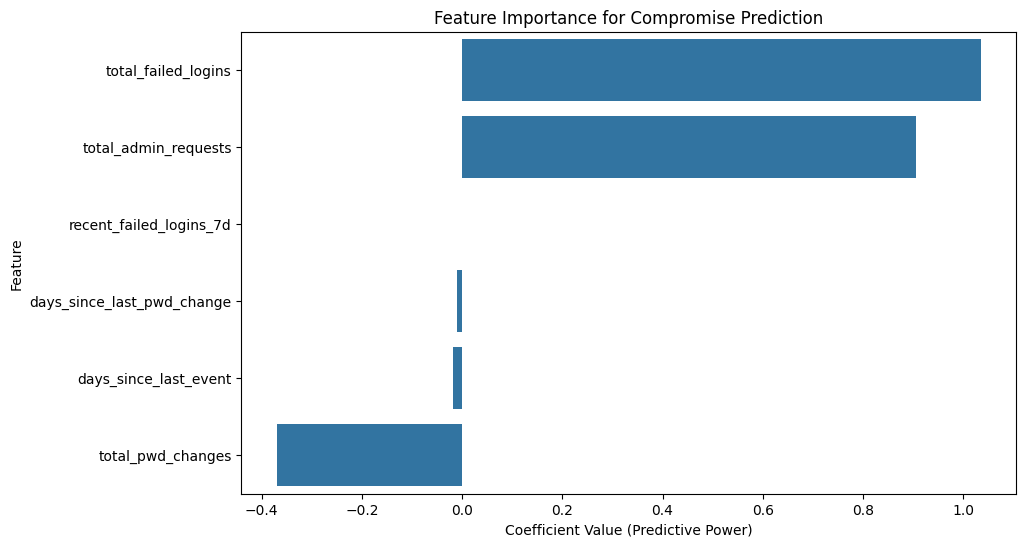


--- Portfolio Key Findings ---
Top 3 Most Predictive Features:
                   Feature  Coefficient
0      total_failed_logins     1.035806
1     total_admin_requests     0.906067
3  recent_failed_logins_7d     0.000000

Actionable Insight: The False Negatives (actual compromised accounts missed) are critical. The Confusion Matrix helps the security team set alert priorities.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.impute import SimpleImputer # For handling NULLs from SQL
from google.cloud import bigquery

def download_table(project_id, data_set_id, table_name):
    client = bigquery.Client(project=project_id)
    table_ref = client.dataset(data_set_id).table(table_name)
    table = client.get_table(table_ref)
    df = client.list_rows(table).to_dataframe()
    return df

# Download the table
df = download_table(project_id, data_set_id, table_name)
# --- 1. Load Data and Initial Cleanup ---
# df = pd.read_csv('user_features_for_ml.csv')

# Handle NULLs: Days since last password change will be NULL if no change ever occurred.
# Impute these with a large number (e.g., 365 days) or the median.
# We will use the median of the existing data to avoid introducing outliers.
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[['days_since_last_pwd_change']] = imputer.fit_transform(df[['days_since_last_pwd_change']])

# Drop the user_id (it's an identifier, not a feature)
df_features = df.drop(columns=['user_id', 'is_compromised'])
target = df['is_compromised']

# --- 2. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    df_features, target, test_size=0.2, random_state=42, stratify=target
)

# --- 3. Train the Model (Logistic Regression) ---
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# --- 4. Evaluate Model ---
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 5. Visualization 1: Confusion Matrix (Model Performance) ---
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low Risk (0)', 'Predicted High Risk (1)'],
            yticklabels=['Actual Low Risk (0)', 'Actual High Risk (1)'])
plt.title('Security Compromise Risk Confusion Matrix')
plt.ylabel('Actual Risk')
plt.xlabel('Predicted Risk')
plt.savefig('confusion_matrix.png')
plt.show()

# --- 6. Visualization 2: Feature Importance ---
# For Logistic Regression, coefficients show importance and direction
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance for Compromise Prediction')
plt.xlabel('Coefficient Value (Predictive Power)')
plt.savefig('feature_importance.png')
plt.show()

# --- 7. Portfolio Conclusion (Print Key Findings) ---
print("\n--- Portfolio Key Findings ---")
print(f"Top 3 Most Predictive Features:")
print(feature_importance.head(3))
print("\nActionable Insight: The False Negatives (actual compromised accounts missed) are critical. The Confusion Matrix helps the security team set alert priorities.")